## Tools and Agents

**Tools** are functions or APIs that extend the model's capabilities, such as calling an external service or performing a calculation. 

**Agents** allow more dynamic usage, enabling the model to decide which tools to use and how many times, adapting to the user's query without a fixed sequence.

# Creating a Tool

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code here


In [1]:
from langchain_core.tools import tool
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent

@tool
def multiply(first_int: int, second_int: int) -> int:
    """Multiply two integers together."""
    return first_int * second_int


In [2]:
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two integers together.
{'first_int': {'title': 'First Int', 'type': 'integer'}, 'second_int': {'title': 'Second Int', 'type': 'integer'}}


### Tool Calling

In [3]:
multiply.invoke({"first_int":7, "second_int": 5})

35

### Chains

*In LangChain, a chain is used when the number of tool invocations is predetermined. For example, a simple chain can be created to multiply two numbers entered by the user. This involves using a tool for multiplication in a fixed sequence of steps. In this case, the chain would take the user’s inputs, multiply them using the specified tool, and return the result.**

**Tool or function calling allows language models to use external tools by invoking APIs, often called function calls.** 

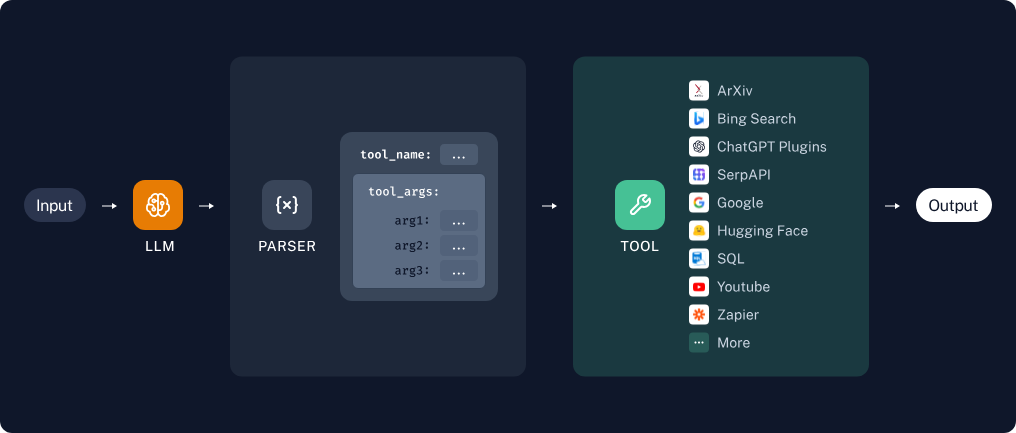

#### Credits: LangChain

# Invoking the tool

In [4]:
# get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

from getpass import getpass

inference_api_key = getpass()

 ········


In [5]:
import os

os.environ["inference_api_key"] = inference_api_key

In [42]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
repo_id ="meta-llama/Meta-Llama-3-8B-Instruct" #"meta-llama/Llama-3.2-1B-Instruct" 

llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    task="text-generation",
    huggingfacehub_api_token=inference_api_key,
    max_new_tokens=128
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\siddhanna.janai\.cache\huggingface\token
Login successful


In [43]:
chat_model = ChatHuggingFace(llm=llm)

llm_with_tools = chat_model.bind_tools([multiply])
msg = llm_with_tools.invoke("whats 4 times twenty two?")
msg.tool_calls

[{'name': 'multiply',
  'args': {'first_int': 4, 'second_int': 22},
  'id': '0',
  'type': 'tool_call'}]

In [44]:
from operator import itemgetter

chain = llm_with_tools | (lambda x: x.tool_calls[0]["args"]) | multiply
chain.invoke("whats 4 times twenty two")

88

# Agents

Agents simplify using multiple tools by dynamically selecting and managing them based on the input. Instead of following a fixed sequence, agents decide which tool to use and how many times, offering flexibility. 

###### Output parsers help structure the text responses from language models (LLMs) into a more useful format.

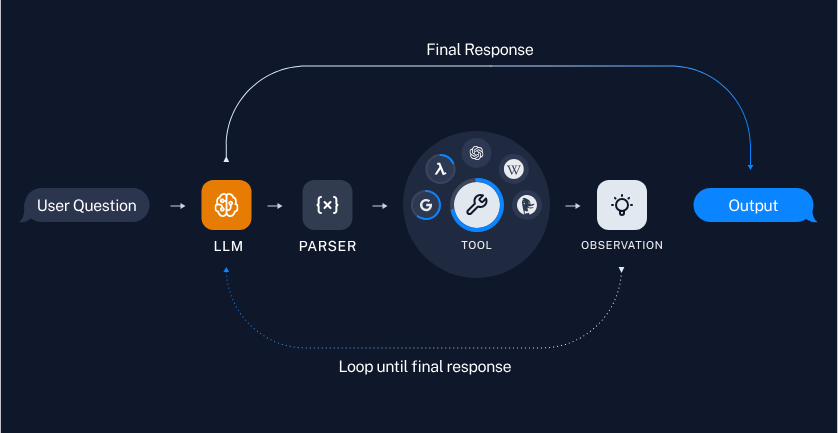

#### Credits: LangChain

https://python.langchain.com/v0.1/docs/use_cases/tool_use/multiple_tools/

In [45]:
# Get the prompt to use - can be replaced with any prompt that includes variables "agent_scratchpad" and "input"!
from langchain import hub
prompt = hub.pull("hwchase17/openai-tools-agent")
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


In [46]:
@tool
def add(first_int: int, second_int: int) -> int:
    "Add two integers."
    return first_int + second_int


@tool
def exponentiate(base: int, exponent: int) -> int:
    "Exponentiate the base to the exponent power."
    return base**exponent


tools = [multiply, add, exponentiate]
llm_with_tools = chat_model.bind_tools([multiply, add, exponentiate])

In [47]:
# Construct the tool calling agent
agent = create_tool_calling_agent(llm_with_tools, tools, prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


In [48]:
#agent

In [54]:
agent_executor.invoke(
    {
        "input": "3 * 24+44  "
    }
)



> Entering new AgentExecutor chain...

Invoking: `multiply` with `{'first_int': 3, 'second_int': 24}`


72
Invoking: `add` with `{'first_int': 72, 'second_int': 44}`


116
Invoking: `multiply` with `{'first_int': 3, 'second_int': 24}`


72
Invoking: `add` with `{'first_int': 3, 'second_int': 24}`


27
Invoking: `multiply` with `{'first_int': 3, 'second_int': 24}`


72
Invoking: `add` with `{'first_int': 72, 'second_int': 44}`


116
Invoking: `multiply` with `{'first_int': 3, 'second_int': 24}`


72
Invoking: `add` with `{'first_int': 3, 'second_int': 24}`


27
Invoking: `multiply` with `{'first_int': 3, 'second_int': 24}`


72
Invoking: `add` with `{'first_int': 72, 'second_int': 44}`


116
Invoking: `multiply` with `{'base': 3, 'exponent': 24}`




ValidationError: 2 validation errors for multiply
first_int
  Field required [type=missing, input_value={'base': 3, 'exponent': 24}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
second_int
  Field required [type=missing, input_value={'base': 3, 'exponent': 24}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing